# Setup

In [1]:
# When working in AI LRZq
%cd ~/cma/CMA_Fairness_v2

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%run analysis_setup_cp.ipynb

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2
The data has N = 900 rows and N = 14 columns.


## Prepare Data


In [3]:
import pandas as pd
from pathlib import Path

RUN_TO_ANALYSE = "1"
CP_DIR = Path("output") / "runs" / str(RUN_TO_ANALYSE)

df_agg = pd.read_csv(CP_DIR / "combined_cp_metrics.csv")

In [4]:
df_agg.head()

,universe_id,universe_training_year,universe_training_size,universe_scale,universe_model,universe_exclude_features,universe_exclude_subgroups,q_hat,coverage,avg_size,cov_frau1,cov_nongerman,cov_nongerman_male,cov_nongerman_female
0,2355d7bfe8294f8157de46ed8edc7bf7,2014,5k,do-not-scale,logreg,nationality-sex,keep-all,0.681470,0.910935,1.197302,0.908505,0.924886,0.940286,0.899404
1,2d16c60d03d38e12b7f8b53c6c0ec18a,2014,25k,scale,rf,nationality,drop-non-german,0.670000,0.916286,1.156972,0.916458,0.914220,0.927947,0.891505
2,fbcced2a4402ef744c7575370b1a9ef1,2012_14,5k,scale,gbm,nationality-sex,keep-all,0.691121,0.909430,1.123097,0.904974,0.906978,0.924255,0.878390
3,226a506f4560c0375082c005cb7fdde2,2012_14,25k,do-not-scale,elasticnet,sex,drop-non-german,0.657530,0.913911,1.249136,0.912765,0.960927,0.968117,0.949031
4,3e3aba496858c4fcba82d2d8c53d6960,2012_14,5k,do-not-scale,elasticnet,age,drop-non-german,0.670935,0.912641,1.280058,0.909314,0.965531,0.974061,0.951416


In [5]:
df_agg.shape

(900, 14)

In [33]:
main_cp_metric = "cov_nongerman_female" # "avg_size", "cov_nongerman_female"

# Calculate Variable Importance

## Use a Lasso Regression to estimate Importance of Settings

In [34]:
cols_design_dec = ["universe_training_year", 
                   "universe_training_size", 
                   "universe_scale",
                   "universe_model", 
                   "universe_exclude_features", 
                   "universe_exclude_subgroups"]
X = df_agg[cols_design_dec]
y = df_agg[main_cp_metric]

In [35]:
X.head()

,universe_training_year,universe_training_size,universe_scale,universe_model,universe_exclude_features,universe_exclude_subgroups
0,2014,5k,do-not-scale,logreg,nationality-sex,keep-all
1,2014,25k,scale,rf,nationality,drop-non-german
2,2012_14,5k,scale,gbm,nationality-sex,keep-all
3,2012_14,25k,do-not-scale,elasticnet,sex,drop-non-german
4,2012_14,5k,do-not-scale,elasticnet,age,drop-non-german


In [36]:
X.shape

(900, 6)

In [37]:
y.shape

(900,)

### Main Effects of Settings Only (i.e. no interactions)

In [38]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV

# Do preprocessing in a separate pipeline from model fitting
# (for eli5 to work)
preprocessor = make_pipeline(
    OneHotEncoder(), 
).fit(X) 
X_processed = preprocessor.transform(X) 

# Fit a Lasso regression model with cross-validation to the processed data
lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data

0.6176090222875822

R² = 1.0: Perfect predictions

R² = 0.0: Model does no better than predicting the mean

R² < 0.0: Model is worse than just predicting the mean

Weights of importance:

In [39]:
# Visualize the importance of each feature in trained lasso_reg model
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())

Weight?,Feature
+0.885,<BIAS>
+0.028,universe_scale_do-not-scale
+0.016,universe_model_elasticnet
+0.005,universe_exclude_features_age
+0.002,universe_training_year_2010_14
+0.001,universe_training_size_25k
+0.001,universe_exclude_subgroups_drop-non-german
+0.000,universe_model_logreg
-0.000,universe_exclude_subgroups_keep-all
-0.000,universe_scale_scale


### Including Interactions

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LassoCV

# Do preprocessing w/o a pipeline for eli5 to work
preprocessor = make_pipeline(
    OneHotEncoder(),
    PolynomialFeatures(degree=2),
).fit(X)
X_processed = preprocessor.transform(X)

lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data

0.9498148536882058

Weights of importance:

In [41]:
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())

Weight?,Feature
+0.887,<BIAS>
+0.043,universe_scale_do-not-scale universe_model_elasticnet
+0.017,universe_scale_do-not-scale
+0.016,universe_model_penalized_logreg universe_exclude_features_age
+0.015,universe_model_logreg universe_exclude_features_age
+0.012,universe_scale_do-not-scale universe_exclude_features_age
+0.008,universe_scale_do-not-scale universe_model_penalized_logreg
+0.007,universe_scale_do-not-scale universe_model_logreg
+0.006,universe_training_year_2010_14 universe_training_size_5k
+0.005,universe_training_year_2014 universe_training_size_25k


## Use a functinoal ANOVA (fANOVA) to Analyze Setting Importance

Based on the following paper:

Hutter, F., Hoos, H., & Leyton-Brown, K. (2014). An Efficient Approach for Assessing Hyperparameter Importance. Proceedings of the 31st International Conference on Machine Learning, 754–762. https://proceedings.mlr.press/v32/hutter14.html


In [42]:
from fairness_multiverse.analysis import MultiverseFanova

m_fanova = MultiverseFanova(features = df_agg[cols_design_dec], outcome = df_agg[main_cp_metric])

In [43]:
m_fanova.quantify_individual_importance()

,individual importance,total importance,individual std,total std
universe_exclude_features,0.009444,0.009444,0.001768,0.001768
universe_exclude_subgroups,0.000502,0.000502,0.000170,0.000170
universe_model,0.289223,0.289223,0.006734,0.006734
universe_scale,0.314974,0.314974,0.006270,0.006270
universe_training_size,0.001218,0.001218,0.000317,0.000317
universe_training_year,0.001435,0.001435,0.000316,0.000316


In [44]:
m_fanova.quantify_importance(save_to = CP_DIR/ f"fanova_importance_interactions-overall_{main_cp_metric}.csv")

,level_0,level_1,level_2,level_3,level_4,level_5,individual importance,total importance,individual std,total std
3,universe_scale,NaN,NaN,NaN,NaN,NaN,0.314974,0.314974,0.006270,0.006270
2,universe_model,NaN,NaN,NaN,NaN,NaN,0.289223,0.289223,0.006734,0.006734
15,universe_model,universe_scale,NaN,NaN,NaN,NaN,0.263456,0.867653,0.008758,0.009284
25,universe_exclude_features,universe_model,universe_scale,NaN,NaN,NaN,0.025111,0.944065,0.003412,0.013628
7,universe_exclude_features,universe_model,NaN,NaN,NaN,NaN,0.021029,0.319697,0.002778,0.008294
...,...,...,...,...,...,...,...,...,...,...
14,universe_exclude_subgroups,universe_training_year,NaN,NaN,NaN,NaN,0.000200,0.002137,0.000145,0.000413
45,universe_exclude_features,universe_exclude_subgroups,universe_scale,universe_training_year,NaN,NaN,0.000193,0.354149,0.000163,0.007113
51,universe_exclude_subgroups,universe_model,universe_scale,universe_training_size,NaN,NaN,0.000187,0.885803,0.000113,0.009941
35,universe_exclude_subgroups,universe_scale,universe_training_year,NaN,NaN,NaN,0.000171,0.321146,0.000181,0.006932


In [45]:
# Latex Table "10 most important decisions or decision interactions"

pd.set_option('display.max_colwidth', None)  

fanova_df = m_fanova.quantify_importance()

top10 = (
    fanova_df
    .sort_values('individual importance', ascending=False)
    .head(10)
    .reset_index(drop=True)
)

# Detect main vs. N-way interaction
def effect_type(row):
    levels = [row[f'level_{i}'] for i in range(5) if pd.notna(row.get(f'level_{i}'))]
    return 'main' if len(levels) == 1 else f'{len(levels)}-way int.'

top10['Effect Type'] = top10.apply(effect_type, axis=1)

def clean_level(name: str) -> str:
    if pd.isna(name): 
        return ""
    # strip leading universe_
    if name.startswith("universe_"):
        name = name[len("universe_"):]
    # snake_case → CamelCase
    return "".join(part.capitalize() for part in name.split("_"))

def fmt_level(name: str) -> str:
    return f"\\textit{{{clean_level(name)}}}"

top10["Decision / Interaction of Decisions"] = (
    top10
    .apply(
        lambda row: " $\\times$ ".join(
            fmt_level(row[f"level_{i}"])
            for i in range(5)                      # loop over 0–4
            if pd.notna(row.get(f"level_{i}"))
        ),
        axis=1,
    )
)

out = top10[[
    'Effect Type',
    'Decision / Interaction of Decisions',
    'individual importance',
    'individual std'
]].copy()
out.columns = [
    'Effect Type',
    'Decision / Interaction of Decisions',
    'Importance',
    'Std. Deviation'
]

out['Importance']    = out['Importance'].round(3)
out['Std. Deviation']= out['Std. Deviation'].round(3)

raw = out.to_latex(
    index=False,
    escape=False,       
    column_format='llrr'
)

lines = raw.splitlines()
new_lines = []
hcount = 0
for ln in lines:
    if ln.strip() == r'\hline':
        hcount += 1
        if hcount == 1:
            new_lines.append(r'\toprule')
        elif hcount == 2:
            new_lines.append(r'\midrule')
        else:
            new_lines.append(r'\bottomrule')
    else:
        new_lines.append(ln)
fixed_tabular = "\n".join(new_lines)

# 9. wrap in full table environment
latex = f"""\\begin{{table}}
\\centering
\\caption{{The 10 most important decisions or decision interactions and their relative importance for the average prediction set size.}}
\\label{{tab:fanova_top10}}
{fixed_tabular}
\\end{{table}}
"""

output_path = CP_DIR / f"fanova_top10_{main_cp_metric}.tex"
output_path.write_text(latex)

/tmp/ipykernel_3905387/888124175.py:61: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  raw = out.to_latex(


1604

# Visualizations Avg. Prediction Set Size

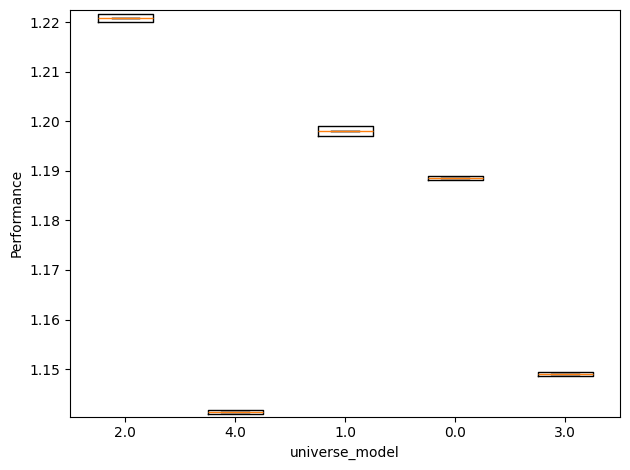

In [12]:
# Plot 1D marginal
from fanova import visualizer

vis = visualizer.Visualizer(m_fanova.fanova, m_fanova.configuration_space, directory = str(CP_DIR))
vis.plot_marginal(2)

In [13]:
# Recover mapping
col = "universe_model"
original_labels = df_agg[col].unique()

# Get corresponding numeric codes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
codes = le.fit_transform(df_agg[col].values)
label_map = dict(zip(le.transform(original_labels), original_labels))

# Sort by code
label_map = dict(sorted(label_map.items()))
print(label_map)

{0: 'elasticnet', 1: 'gbm', 2: 'logreg', 3: 'penalized_logreg', 4: 'rf'}


/tmp/ipykernel_3905387/1205111228.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(renamed, fontsize=category_label_size, rotation=30)
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_3905387/1205111228.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of

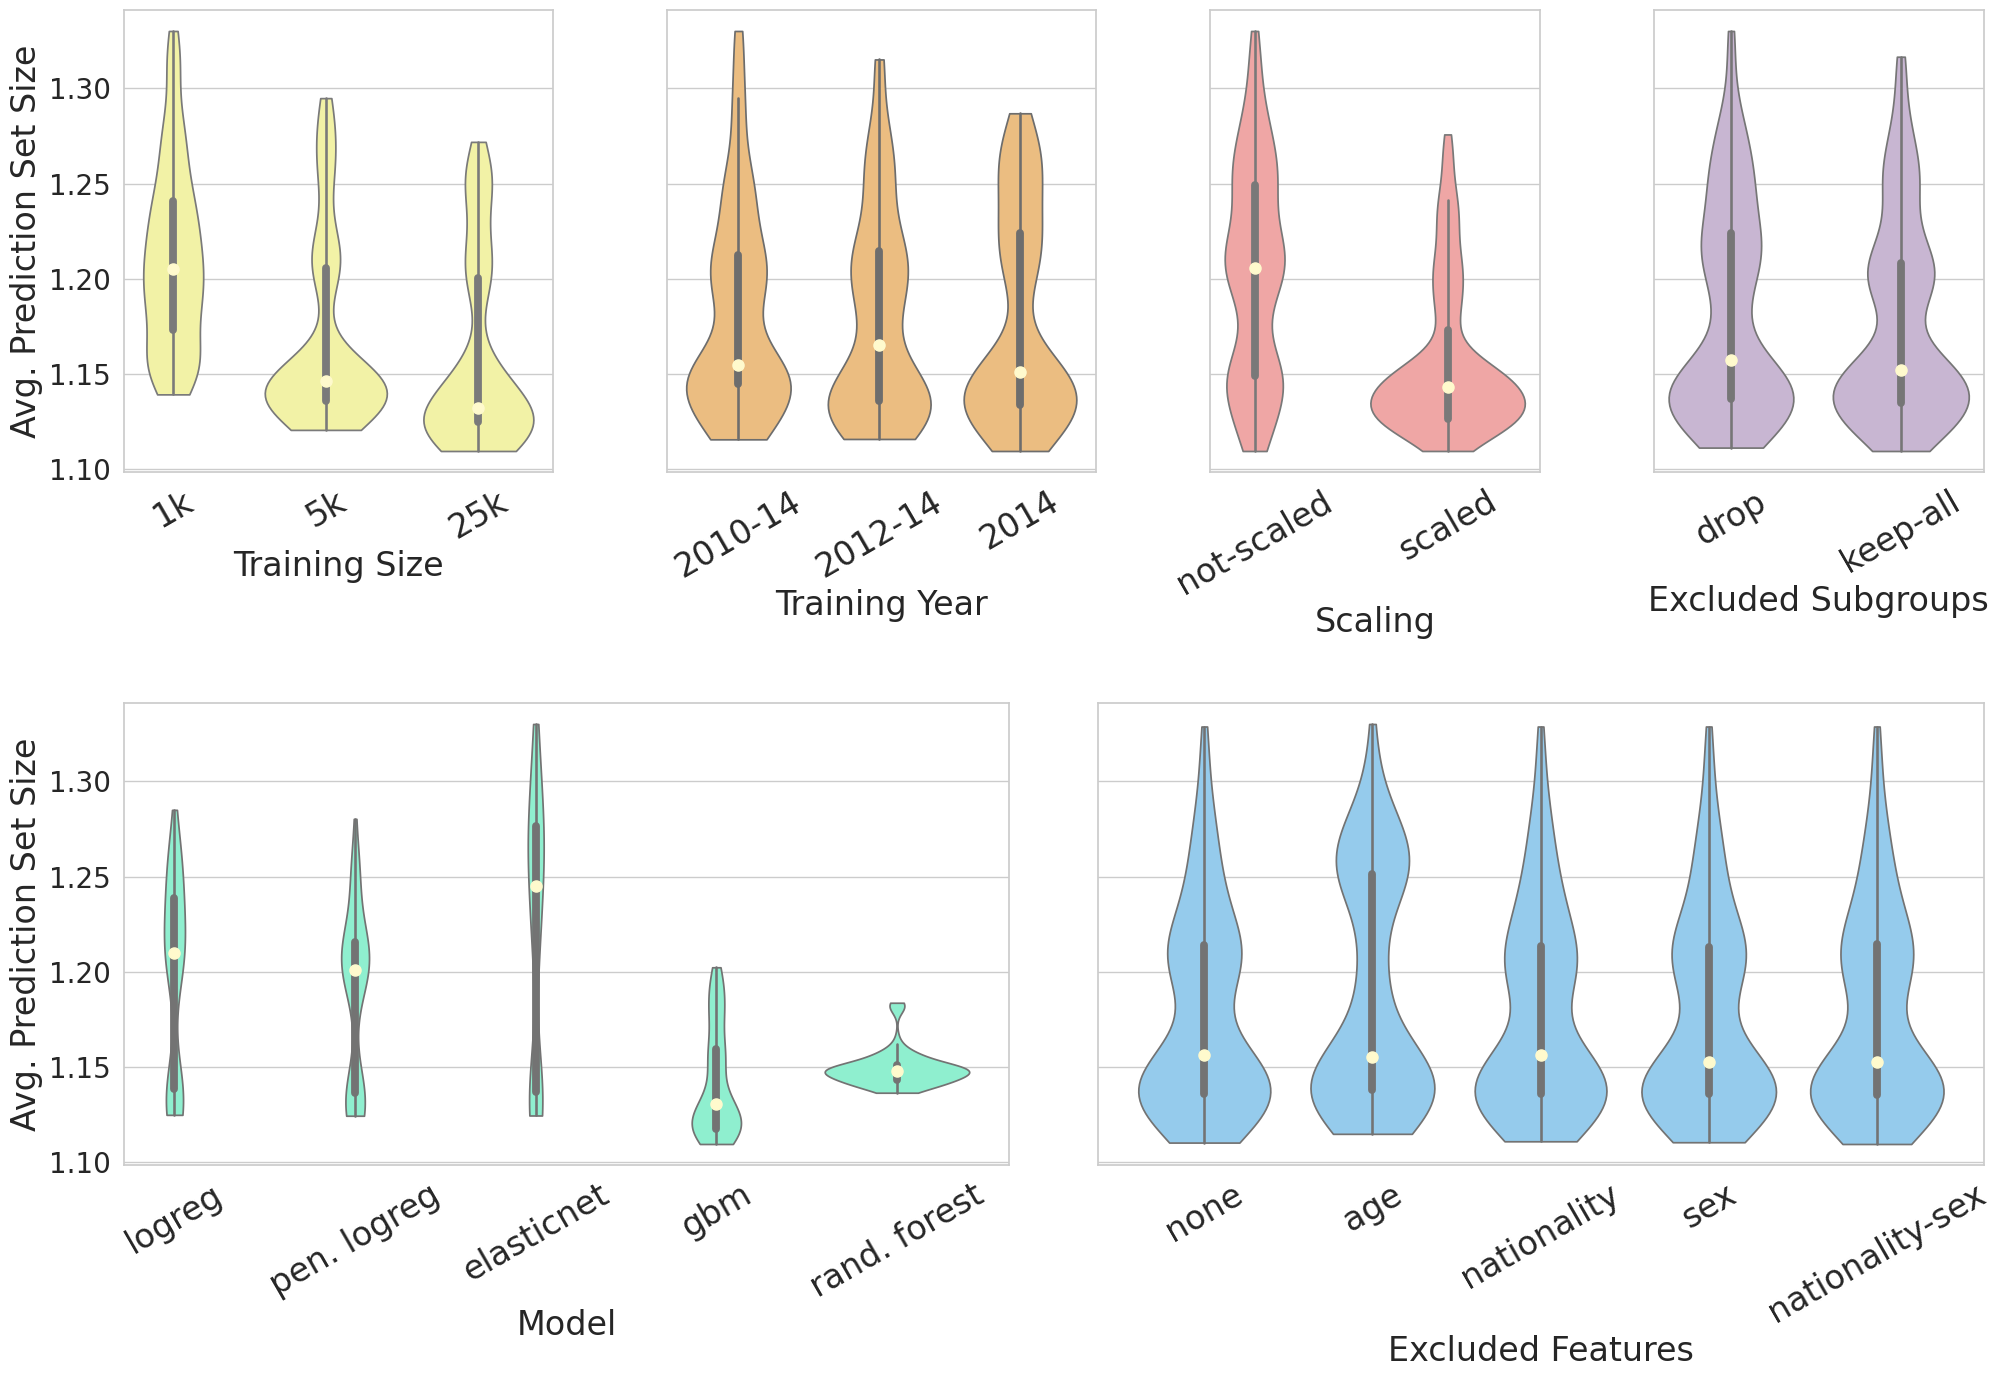

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Label mapping
label_map = {
    'universe_training_size': 'Training Size',
    'universe_training_year': 'Training Year',
    'universe_scale': 'Scaling',
    'universe_model': 'Model',
    'universe_exclude_features': 'Excluded Features',
    'universe_exclude_subgroups': 'Excluded Subgroups'
}

# Custom x-tick renaming
category_renames = {
    '2010_14': '2010-14',
    '2012_14': '2012-14',
    'scale': 'scaled',
    'do-not-scale': 'not-scaled',
    'drop-non-german': 'drop',
    'penalized_logreg': 'pen. logreg',
    'rf': 'rand. forest'
}

# Custom order per parameter
custom_orders = {
    'universe_training_size': ['1k', '5k', '25k'],
    'universe_model': ['logreg', 'penalized_logreg', 'elasticnet', 'gbm', 'rf'],
    'universe_exclude_features': ['none', 'age', 'nationality', 'sex', 'nationality-sex']
}

# Plot layout
row1 = [
    'universe_training_size',
    'universe_training_year',
    'universe_scale',
    'universe_exclude_subgroups'
]
row2 = ['universe_model', 'universe_exclude_features']

widths_row1 = [1.3, 1.3, 1.0, 1.0]
widths_row2 = [2.0, 2.0] 

colors_row1 = ['#FFFF99', '#FDBF6F', '#FB9A99', '#CAB2D6']
colors_row2 = ['aquamarine', 'lightskyblue'] 

# Styling
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)
fig = plt.figure(figsize=(24, 15))
outer_gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.5)

# Font sizes
axis_label_size = 24
tick_label_size = 20
category_label_size = 24

# Row 1
gs_row1 = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=4, subplot_spec=outer_gs[0], width_ratios=widths_row1, wspace=0.3
)

for idx, param in enumerate(row1): 
    ax = fig.add_subplot(gs_row1[0, idx]) 

    order = custom_orders.get(param, sorted(df_agg[param].dropna().unique()))
    sns.violinplot(
        data=df_agg, x=param, y='avg_size', ax=ax,
        inner='box', cut=0, order=order, color=colors_row1[idx]
    )

    # Overlay median dots
    medians = df_agg.groupby(param)['avg_size'].median()
    for i, cat in enumerate(order):
        if cat in medians:
            ax.plot(i, medians[cat], color='lemonchiffon', marker='o', markersize=8, zorder=3)

    # Rename x-tick labels
    xticks = [label.get_text() for label in ax.get_xticklabels()]
    renamed = [category_renames.get(label, label) for label in xticks]
    ax.set_xticklabels(renamed, fontsize=category_label_size, rotation=30)

    ax.set_xlabel(label_map[param], fontsize=axis_label_size)
    if idx == 0:
        ax.set_ylabel('Avg. Prediction Set Size', fontsize=axis_label_size)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.tick_params(axis='y', left=False)
    ax.tick_params(axis='y', labelsize=tick_label_size)
    ax.set_title("")

# Row 2
gs_row2 = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=2, subplot_spec=outer_gs[1], width_ratios=widths_row2, wspace=0.1
)
for idx, param in enumerate(row2): 
    ax = fig.add_subplot(gs_row2[0, idx])  

    order = custom_orders.get(param, sorted(df_agg[param].dropna().unique()))
    sns.violinplot(
        data=df_agg, x=param, y='avg_size', ax=ax,
        inner='box', cut=0, order=order, color=colors_row2[idx]
    )

    # Overlay median dots
    medians = df_agg.groupby(param)['avg_size'].median()
    for i, cat in enumerate(order):
        if cat in medians:
            ax.plot(i, medians[cat], color='lemonchiffon', marker='o', markersize=8, zorder=3)

    # Rename x-tick labels
    xticks = [label.get_text() for label in ax.get_xticklabels()]
    renamed = [category_renames.get(label, label) for label in xticks]
    ax.set_xticklabels(renamed, fontsize=category_label_size, rotation=30)

    ax.set_xlabel(label_map[param], fontsize=axis_label_size)
    if idx == 0:
        ax.set_ylabel('Avg. Prediction Set Size', fontsize=axis_label_size)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.tick_params(axis='y', left=False)
    ax.tick_params(axis='y', labelsize=tick_label_size)
    ax.set_title("")

output_path = CP_DIR / f"violin_plots_{main_cp_metric}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

In [16]:
# 5 most important 2-way interactions
best_p_margs = m_fanova.fanova.get_most_important_pairwise_marginals(n=5)
print(best_p_margs)

OrderedDict([(('universe_model', 'universe_scale'), 0.16845470399214865), (('universe_model', 'universe_training_size'), 0.035338180878456506), (('universe_scale', 'universe_training_size'), 0.030956288994501223), (('universe_exclude_features', 'universe_model'), 0.005055709495079641), (('universe_exclude_features', 'universe_scale'), 0.003704889743739591)])


In [17]:
from fanova import visualizer

vis = visualizer.Visualizer(m_fanova.fanova, m_fanova.configuration_space, directory = str(CP_DIR))

/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)


<module 'matplotlib.pyplot' from '/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/matplotlib/pyplot.py'>

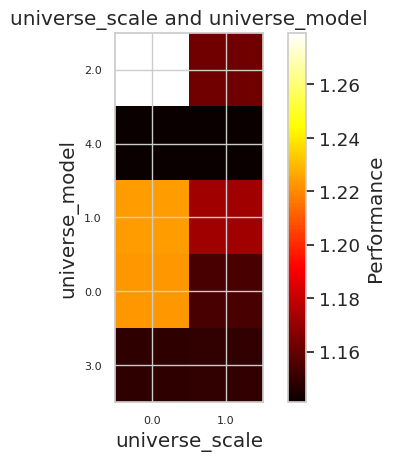

In [18]:
# Plot 2D pairwise marginal
vis.plot_pairwise_marginal(['universe_scale', 'universe_model'])

In [20]:
# Recover mapping
col = "universe_scale"
original_labels = df_agg[col].unique()

# Get corresponding numeric codes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
codes = le.fit_transform(df_agg[col].values)
label_map = dict(zip(le.transform(original_labels), original_labels))

# Sort by code
label_map = dict(sorted(label_map.items()))
print(label_map)

{0: 'do-not-scale', 1: 'scale'}


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)


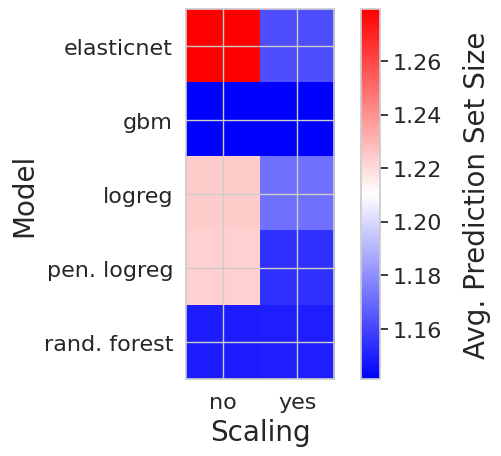

In [25]:
# Heatmap avg. prediction set size

vis.plot_pairwise_marginal(['universe_scale', 'universe_model'])

plt.yticks(
    ticks=[0,1,2,3,4], 
    labels=['elasticnet', 'gbm', 'logreg', 'pen. logreg', 'rand. forest'], 
    fontsize=16)

plt.xticks(
    ticks=[0,1], 
    labels=['no', 'yes'],
    #rotation=45,
    fontsize=16)

cbar = plt.gcf().axes[-1] 
cbar.set_ylabel("Avg. Prediction Set Size", rotation=90, labelpad=15, fontsize=20)
cbar.tick_params(labelsize=16)

plt.ylabel("Model", fontsize=20)
plt.xlabel("Scaling", fontsize=20)

ax = plt.gca()
im = ax.get_images()[0] 
im.set_cmap("bwr")

plt.title("")
plt.tight_layout()

output_path = CP_DIR / f"heatmap_{main_cp_metric}.png"
#plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

# Visualizations Conditional Coverage

/tmp/ipykernel_3905387/2955644581.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(renamed, fontsize=category_label_size, rotation=30)
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_3905387/2955644581.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of

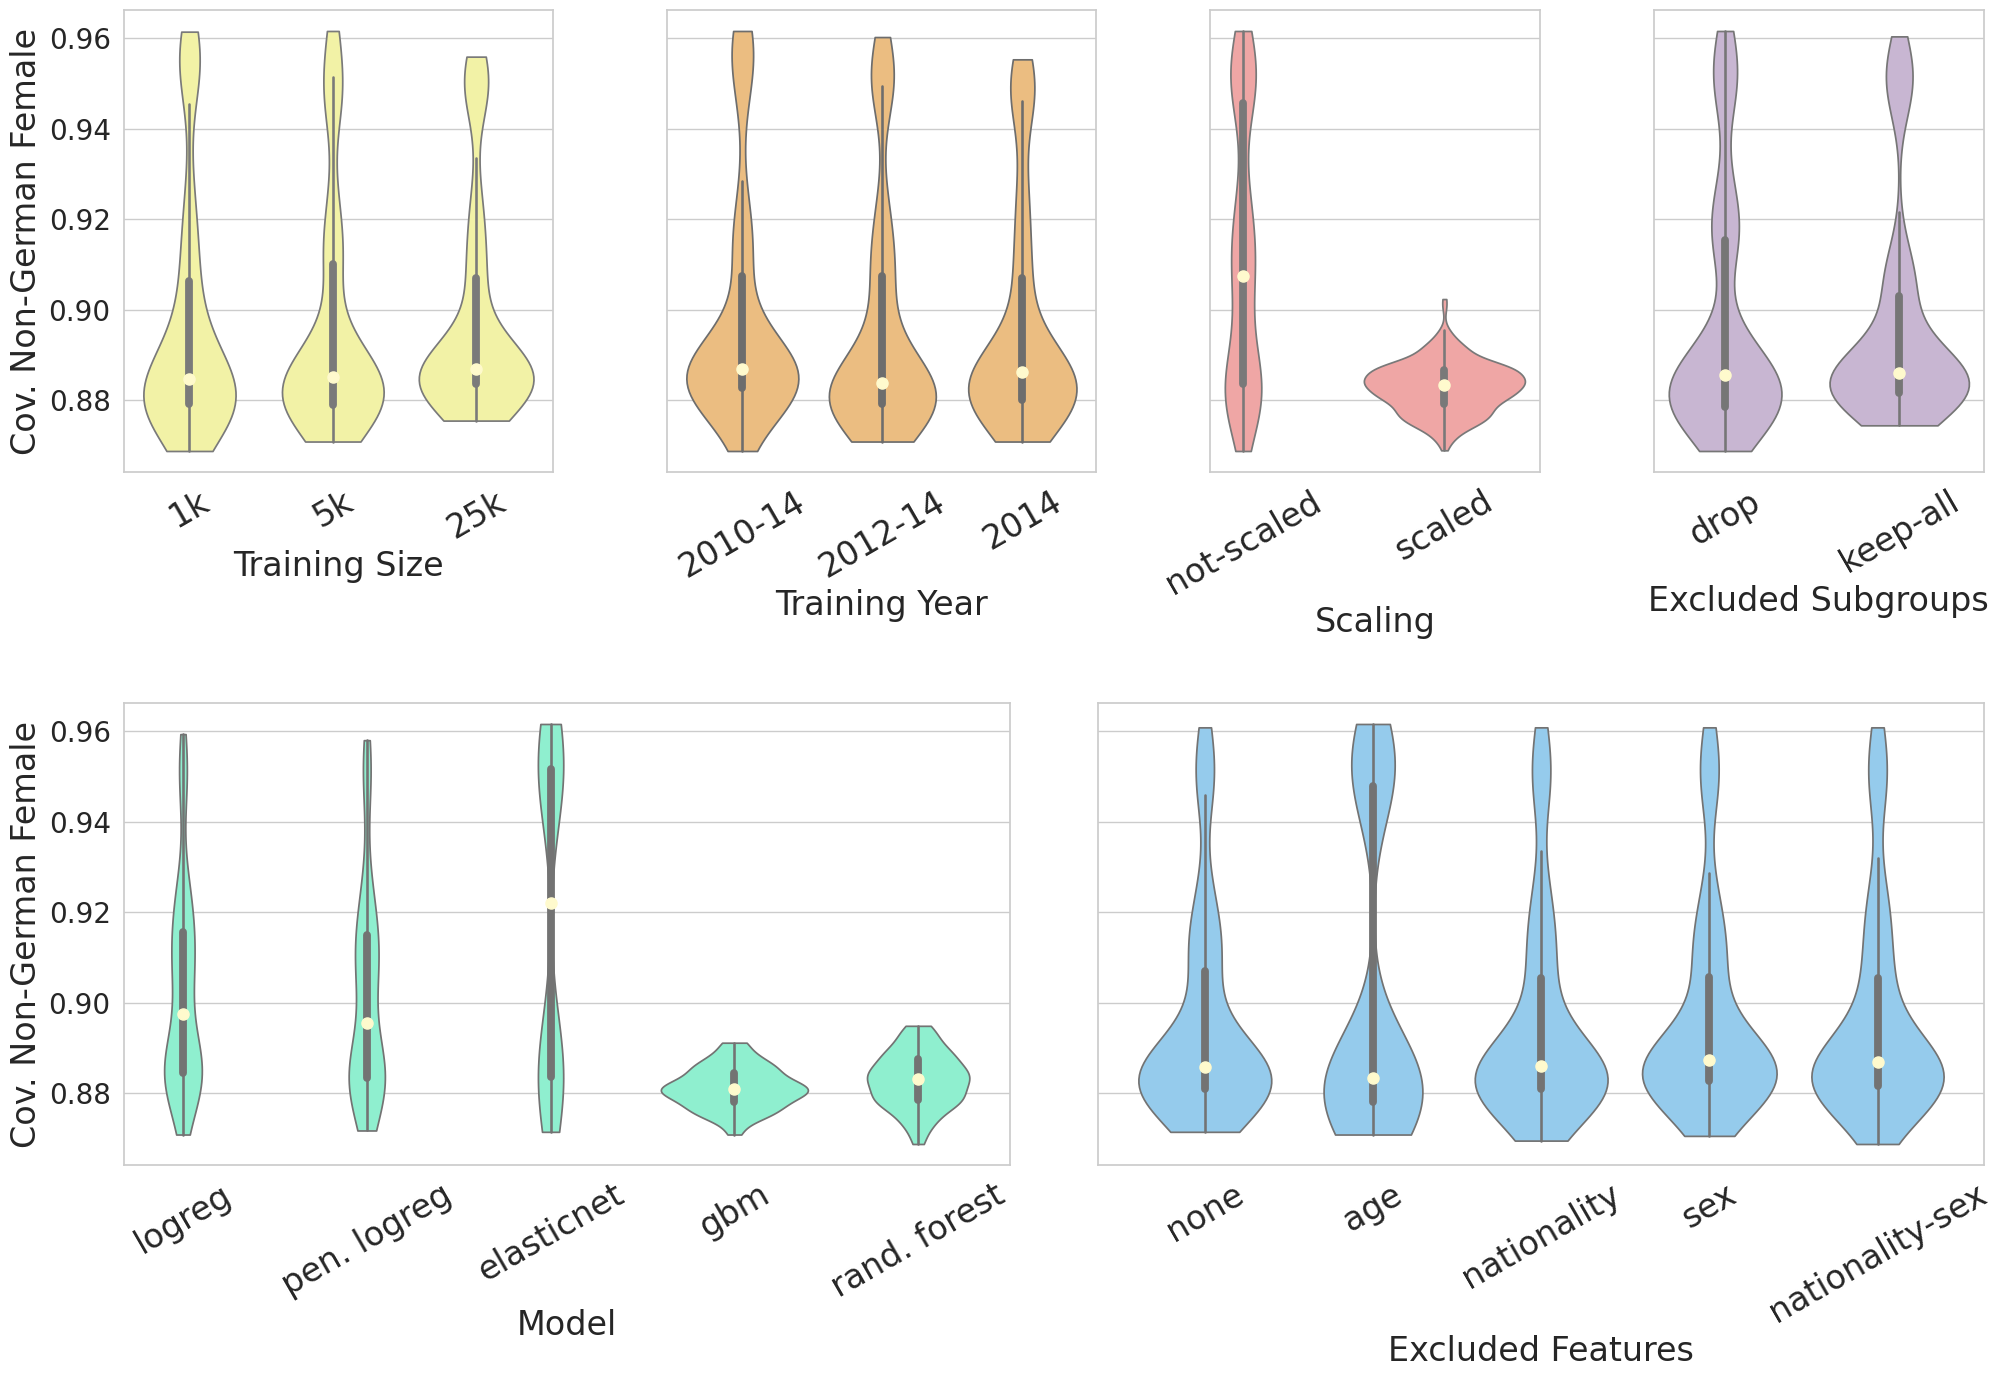

In [46]:
# Violin plots conditional coverage

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Label mapping
label_map = {
    'universe_training_size': 'Training Size',
    'universe_training_year': 'Training Year',
    'universe_scale': 'Scaling',
    'universe_model': 'Model',
    'universe_exclude_features': 'Excluded Features',
    'universe_exclude_subgroups': 'Excluded Subgroups'
}

# Custom x-tick renaming
category_renames = {
    '2010_14': '2010-14',
    '2012_14': '2012-14',
    'scale': 'scaled',
    'do-not-scale': 'not-scaled',
    'drop-non-german': 'drop',
    'penalized_logreg': 'pen. logreg',
    'rf': 'rand. forest'
}

# Custom order per parameter
custom_orders = {
    'universe_training_size': ['1k', '5k', '25k'],
    'universe_model': ['logreg', 'penalized_logreg', 'elasticnet', 'gbm', 'rf'],
    'universe_exclude_features': ['none', 'age', 'nationality', 'sex', 'nationality-sex']
}

# Plot layout
row1 = [
    'universe_training_size',
    'universe_training_year',
    'universe_scale',
    'universe_exclude_subgroups'
]
row2 = ['universe_model', 'universe_exclude_features']

widths_row1 = [1.3, 1.3, 1.0, 1.0]
widths_row2 = [2.0, 2.0]

colors_row1 = ['#FFFF99', '#FDBF6F', '#FB9A99', '#CAB2D6']
colors_row2 = ['aquamarine', 'lightskyblue'] 

# Styling
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)
fig = plt.figure(figsize=(24, 15))
outer_gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.5)

# Font sizes
axis_label_size = 24
tick_label_size = 20
category_label_size = 24

# Row 1
gs_row1 = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=4, subplot_spec=outer_gs[0], width_ratios=widths_row1, wspace=0.3
)

for idx, param in enumerate(row1): 
    ax = fig.add_subplot(gs_row1[0, idx]) 

    order = custom_orders.get(param, sorted(df_agg[param].dropna().unique()))
    sns.violinplot(
        data=df_agg, x=param, y='cov_nongerman_female', ax=ax,
        inner='box', cut=0, order=order, color=colors_row1[idx]
    )

    # Overlay median dots
    medians = df_agg.groupby(param)['cov_nongerman_female'].median()
    for i, cat in enumerate(order):
        if cat in medians:
            ax.plot(i, medians[cat], color='lemonchiffon', marker='o', markersize=8, zorder=3)

    # Rename x-tick labels
    xticks = [label.get_text() for label in ax.get_xticklabels()]
    renamed = [category_renames.get(label, label) for label in xticks]
    ax.set_xticklabels(renamed, fontsize=category_label_size, rotation=30)

    ax.set_xlabel(label_map[param], fontsize=axis_label_size)
    if idx == 0:
        ax.set_ylabel('Cov. Non-German Female', fontsize=axis_label_size)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.tick_params(axis='y', left=False)
    ax.tick_params(axis='y', labelsize=tick_label_size)
    ax.set_title("")

# Row 2
gs_row2 = gridspec.GridSpecFromSubplotSpec(
    nrows=1, ncols=2, subplot_spec=outer_gs[1], width_ratios=widths_row2, wspace=0.1
)
for idx, param in enumerate(row2): 
    ax = fig.add_subplot(gs_row2[0, idx])  

    order = custom_orders.get(param, sorted(df_agg[param].dropna().unique()))
    sns.violinplot(
        data=df_agg, x=param, y='cov_nongerman_female', ax=ax,
        inner='box', cut=0, order=order, color=colors_row2[idx]
    )

    # Overlay median dots
    medians = df_agg.groupby(param)['cov_nongerman_female'].median()
    for i, cat in enumerate(order):
        if cat in medians:
            ax.plot(i, medians[cat], color='lemonchiffon', marker='o', markersize=8, zorder=3)

    # Rename x-tick labels
    xticks = [label.get_text() for label in ax.get_xticklabels()]
    renamed = [category_renames.get(label, label) for label in xticks]
    ax.set_xticklabels(renamed, fontsize=category_label_size, rotation=30)

    ax.set_xlabel(label_map[param], fontsize=axis_label_size)
    if idx == 0:
        ax.set_ylabel('Cov. Non-German Female', fontsize=axis_label_size)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.tick_params(axis='y', left=False)
    ax.tick_params(axis='y', labelsize=tick_label_size)
    ax.set_title("")

output_path = CP_DIR / f"violin_plots_{main_cp_metric}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

In [47]:
# Recover mapping
col = "universe_scale"
original_labels = df_agg[col].unique()

# Get corresponding numeric codes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
codes = le.fit_transform(df_agg[col].values)
label_map = dict(zip(le.transform(original_labels), original_labels))

# Sort by code
label_map = dict(sorted(label_map.items()))
print(label_map)

{0: 'do-not-scale', 1: 'scale'}


In [48]:
from fanova import visualizer

vis = visualizer.Visualizer(m_fanova.fanova, m_fanova.configuration_space, directory = str(CP_DIR))

/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)


<module 'matplotlib.pyplot' from '/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/matplotlib/pyplot.py'>

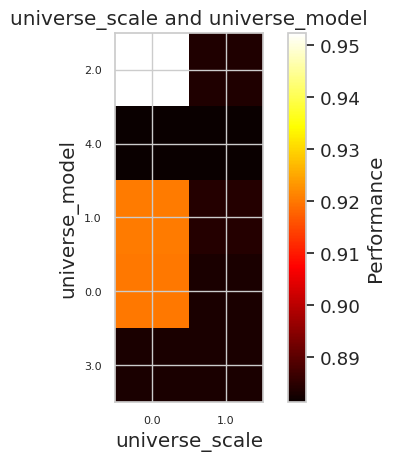

In [49]:
# Plot 2D pairwise marginal
vis.plot_pairwise_marginal(['universe_scale', 'universe_model'])

/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)


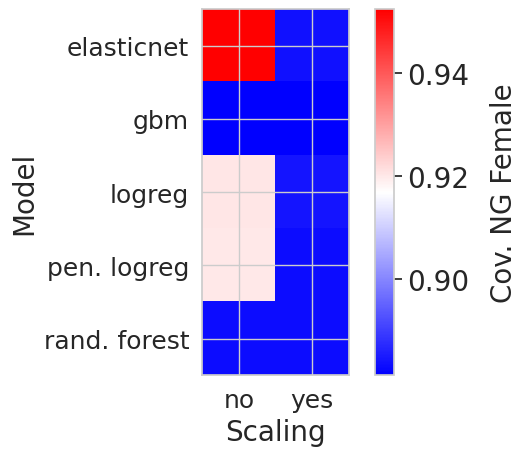

In [53]:
# Heatmap conditional coverage

import matplotlib.pyplot as plt

vis.plot_pairwise_marginal(['universe_scale', 'universe_model'])

plt.yticks(
    ticks=[0,1,2,3,4], 
    labels=['elasticnet', 'gbm', 'logreg', 'pen. logreg', 'rand. forest'], 
    fontsize=18)

plt.xticks(
    ticks=[0,1], 
    labels=['no', 'yes'],
    #rotation=45,
    fontsize=18)

cbar = plt.gcf().axes[-1] 
cbar.set_ylabel("Cov. NG Female", rotation=90, labelpad=15, fontsize=20)
cbar.tick_params(labelsize=20)

plt.xlabel("Scaling", fontsize=20)
plt.ylabel("Model", fontsize=20)

ax = plt.gca()
im = ax.get_images()[0] 
im.set_cmap("bwr") # "bwr_r"


plt.title("")
plt.tight_layout()

output_path = CP_DIR / f"heatmap_{main_cp_metric}.png"
#plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

# Quantify Importance with Partial Data

In [27]:
from tqdm import tqdm

OUTPUT_DIR = Path(".") / "output"

# Directory that will contain outputs from analysis
ANALYSIS_OUTPUT_DIR = OUTPUT_DIR / "analyses" / (str(RUN_TO_ANALYSE))

PARTIAL_FANOVA_DIR = ANALYSIS_OUTPUT_DIR / "partial_fanova" / "overall"
PARTIAL_FANOVA_DIR.mkdir(parents=True, exist_ok=True)

N_ITERATIONS = 10

In [28]:
from fairness_multiverse.analysis import MultiverseFanova
import joblib

def quantify_importance_for_fraction(fraction: float, base_directory = PARTIAL_FANOVA_DIR):
    # Get random subset of the data
    df = df_agg.sample(frac = fraction).reset_index(drop = True)
    data_hash = joblib.hash(df)

    # Create directory for this fraction
    directory = base_directory / f"fraction-{fraction}"
    directory.mkdir(exist_ok = True)

    # Run FANOVA on subset
    partial_fanova = MultiverseFanova(features = df[["universe_model", "universe_exclude_features", "universe_exclude_subgroups"]], outcome = df[main_cp_metric])
    partial_fanova.quantify_importance(save_to = directory / f"partial-fanova_importance_interactions-majmin-{fraction}-{data_hash}.csv")

In [29]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.01)

100%|██████████| 10/10 [00:00<00:00, 26.12it/s]


In [30]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.05)

100%|██████████| 10/10 [00:00<00:00, 18.44it/s]


In [31]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.1)

100%|██████████| 10/10 [00:00<00:00, 18.04it/s]


In [32]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.2)

100%|██████████| 10/10 [00:00<00:00, 17.12it/s]
